In [1]:
import os
import sys
sys.path.append('../src')
import copy
import numpy as np
import torch

from model.model import DecoderNetwork
from synth.parameters_normalizer import Normalizer
from model.loss import spectral_loss
from synth.synth_architecture import SynthModular
from main_hp_search_dec_only import configure_experiment
from dataset.ai_synth_dataset import AiSynthDataset
from synth.synth_constants import synth_constants
from utils.train_utils import to_torch_recursive
from utils.visualization_utils import calc_loss_vs_param_range, plot_loss_vs_param
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# Setup experiment
project_root = r'/home/almogelharar/almog/ai_synth'

exp_name = 'training_visualization_fm_sine'
dataset_name = 'surrogate_lfo_sine_single'
device = 'cpu'

config_path = os.path.join(project_root, 'configs', 'optimization_analysis', 'surrogate_lfo_sine_single_synth_config_hp_search.yaml')
data_path = os.path.join(project_root, 'data', dataset_name, 'train', '')

cfg = configure_experiment(exp_name, dataset_name, config_path, debug=True)

synth = SynthModular(preset_name=cfg.synth.preset,
                     synth_constants=synth_constants,
                     device=device)

decoder_net = DecoderNetwork(preset=cfg.synth.preset, device=device)
normalizer = Normalizer(cfg.synth.note_off_time, cfg.synth.signal_duration, synth_constants)

Deleting previous experiment...


In [3]:
dataset = AiSynthDataset(data_path, noise_std=0)

target_sample = dataset[4]
target_signal, target_param_dict, signal_index = target_sample

target_param_dict = to_torch_recursive(target_param_dict, device, ignore_dtypes=(str, tuple))
target_param_dict[(1, 1)]['parameters']['waveform'] = [target_param_dict[(1, 1)]['parameters']['waveform']]

print(f"target parameters full range: \n{target_param_dict}")


parameters_to_freeze = {(1, 1): {'operation': 'surrogate_lfo',
                                      'parameters': ['freq', 'waveform', 'active']},
                        (0, 2): {'operation': 'surrogate_fm_sine',
                                 'parameters': ['active', 'fm_active', 'amp_c', 'mod_index']}}

target_params_01 = normalizer.normalize(target_param_dict)

decoder_net.apply_params(target_params_01)
decoder_net.freeze_params(parameters_to_freeze)

predicted_params_01 = decoder_net()

predicted_params_full_range = normalizer.denormalize(predicted_params_01)

synth.update_cells_from_dict(predicted_params_full_range)
generated_target_signal, _ = synth.generate_signal(signal_duration=1, batch_size=1)
target_signal = target_signal.to(device)

target parameters full range: 
{(1, 1): {'operation': 'surrogate_lfo', 'parameters': {'active': tensor([True]), 'output': tensor([[0, 2]]), 'freq': tensor([10.2110]), 'waveform': ['sawtooth']}}, (0, 2): {'operation': 'surrogate_fm_sine', 'parameters': {'fm_active': tensor([1], dtype=torch.int32), 'active': tensor([True]), 'amp_c': tensor([0.9022]), 'freq_c': tensor([659.2551]), 'mod_index': tensor([0.0336])}}}
Missing amp param in Oscillator module surrogate_lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.


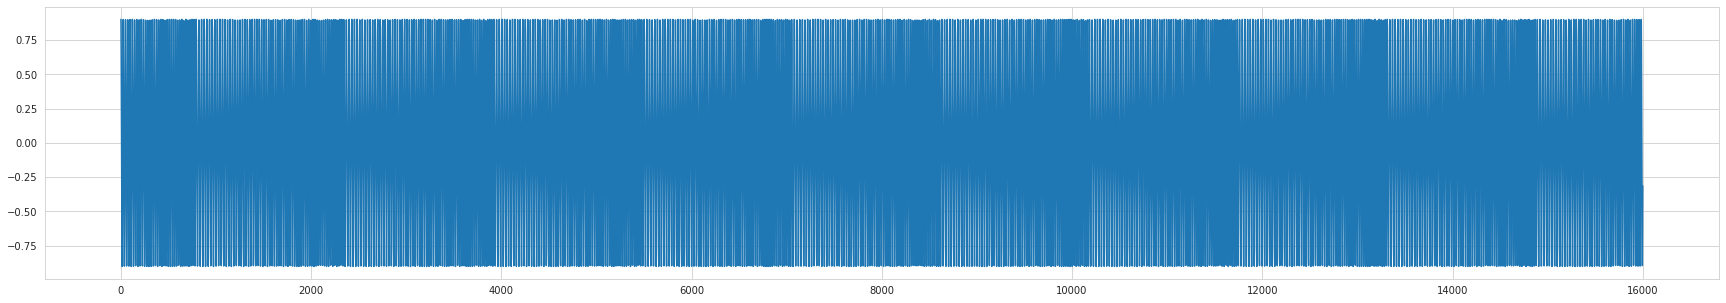

In [4]:
%matplotlib inline


fig, ax = plt.subplots(1, 1, figsize=(30, 5))
ax.plot(target_signal.detach().numpy().squeeze())

In [5]:
cfg.multi_spectral_loss_spec_type = 'SPECTROGRAM'
loss_handler = spectral_loss.SpectralLoss(loss_type=cfg.loss.spec_loss_type,
                                          loss_preset=cfg.loss.preset,
                                          synth_constants=synth_constants, device=device)

params_loss_handler = torch.nn.MSELoss()

/home/almogelharar/almog/ai_synth/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/home/almogelharar/almog/ai_synth/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/home/almogelharar/almog/ai_synth/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(
/home/almogelharar/almog/ai_synth/venv/lib/python3.9/site-packages/torchaudio/functional/functional.py:539: UserWarning: At lea

In [6]:
cell_index = (0, 2)
param_name = 'freq_c'
target_param_val = target_param_dict[cell_index]['parameters'][param_name]

param_to_visualize = {'param_name': param_name, 'cell_index': cell_index, 'min_val': target_param_val ,
                      'max_val': target_param_val, 'n_steps': 1}

loss_vals, param_range, _ = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler, **param_to_visualize)
zero_loss_val = loss_vals[0]

print(zero_loss_val)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 41.04it/s]

8.227136163441173e-07


In [7]:
param_to_visualize = {'param_name': 'freq_c', 'cell_index': (0, 2), 'min_val': 0, 'max_val': 2000, 'n_steps': 2000}

loss_vals, param_range, _ = calc_loss_vs_param_range(synth, target_param_dict, target_signal, loss_handler, **param_to_visualize)

100%|███████████████████████████████████████| 2000/2000 [01:04<00:00, 31.03it/s]


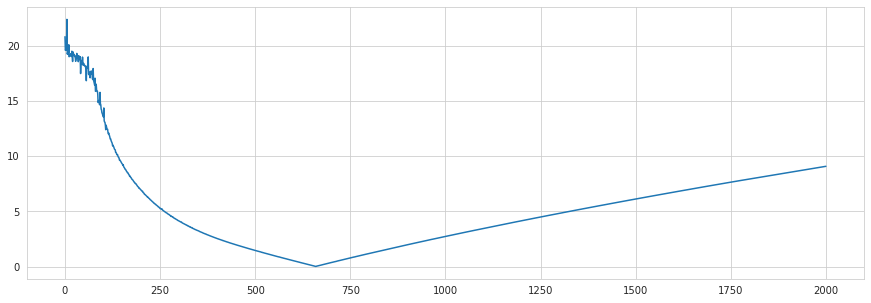

In [8]:
plot_loss_vs_param(param_range, loss_vals, "")


In [14]:
from model.lookahead_optimizer import Lookahead

num_epochs = 1000
starting_frequency = [[-3.]]
decoder_net.apply_params_partial({(0, 2):
                                     {'operation': 'surrogate_fm_sine',
                                      'parameters': {'freq_c': starting_frequency}
                                     }
                                 })
target_signal_unsqueezed = target_signal.to(device).unsqueeze(dim=0)

base_lr = 4e-2
optimizer = torch.optim.Adam(decoder_net.parameters(), lr=base_lr)
# optimizer = Lookahead(optimizer, la_steps=5, la_alpha=0.8)

train_res = []
for e in tqdm(range(num_epochs)):

    predicted_params_01 = decoder_net.forward()

    predicted_params_full_range = normalizer.denormalize(predicted_params_01)
    predicted_freq = predicted_params_full_range[(0, 2)]['parameters']['freq_c']

    synth.update_cells_from_dict(predicted_params_full_range)
    predicted_signal, chain_signal = synth.generate_signal(signal_duration=1)

    loss, _, _ = loss_handler.call(target_signal_unsqueezed, predicted_signal, step=0, return_spectrogram=False)

    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(decoder_net.parameters(), 100)
    optimizer.step()

    train_res.append((e, predicted_freq.item(), loss.detach().numpy().item(), decoder_net.parameters_dict[decoder_net.get_key((0, 2), 'surrogate_fm_sine', 'freq_c')].weight.grad.item()))

100%|███████████████████████████████████████| 1000/1000 [01:35<00:00, 10.43it/s]


/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


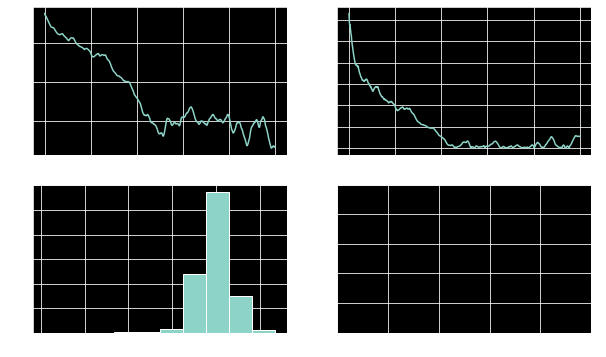

In [15]:
plt.style.use('dark_background')
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0][0].plot([target_param_dict[cell_index]['parameters'][param_name] - x[1] for x in train_res])

axes[0][1].plot([x[2] for x in train_res])

axes[1][0].hist([x[-1] for x in train_res])
plt.show()

# axes[1][1].hist(np.asarray([x[-1] for x in train_res]))
plt.show()

In [11]:
[x[-1] for x in train_res]

[-188.6499481201172,
 -55.324256896972656,
 -22.228574752807617,
 -83.48248291015625,
 50.48832321166992,
 86.79498291015625,
 -118.10255432128906,
 67.05341339111328,
 -67.62798309326172,
 -42.67310333251953,
 -61.234619140625,
 20.939619064331055,
 -47.80968475341797,
 17.25490379333496,
 -27.656423568725586,
 265.4803161621094,
 4.371850967407227,
 133.5224151611328,
 -128.53135681152344,
 7.0124311447143555,
 28.518918991088867,
 10.677690505981445,
 27.436628341674805,
 16.45827293395996,
 -26.96916389465332,
 -15.860647201538086,
 26.144514083862305,
 17.677248001098633,
 19.95269775390625,
 11.279176712036133,
 -78.50841522216797,
 -65.24495697021484,
 -37.77299880981445,
 99.73423767089844,
 100.10678100585938,
 -69.44078826904297,
 -19.186784744262695,
 -49.786277770996094,
 -77.42118835449219,
 27.53816032409668,
 27.029401779174805,
 27.6296329498291,
 -7.330101013183594,
 -42.26759338378906,
 16.465368270874023,
 24.882734298706055,
 1.0485605001449585,
 23.9996280670166,
 

In [16]:
%matplotlib notebook
from matplotlib import animation

fig, ax = plt.subplots(figsize=(15, 5))
l1, = ax.plot(param_range, loss_vals, 'o-', label='loss surface', markevery=[-1])
l2, = ax.plot([], [], 'o-', label='training progress')
ax.legend(loc='center right')
# ax.set_xlim(0,100)
# ax.set_ylim(0,1)

def animate(i):
    xi = [train_res[j][1] for j in range(i)]
    yi = [train_res[j][2] for j in range(i)]
    l2.set_data(xi, yi)
    return (l2)

animation.FuncAnimation(fig, animate, frames=num_epochs, interval=50)

<IPython.core.display.Javascript object>